In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])
import keras
import tensorflow as tf
config = tf.ConfigProto(device_count={"CPU": 4})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

base


Using TensorFlow backend.


In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# basic requirements
import cv2
import numpy as np
import pickle
import pandas as pd

# visualization 
import matplotlib.pyplot as plt

# For creating mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten,Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D,Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.utils import to_categorical,plot_model
from keras import backend as K
from keras import *
from keras.optimizers import *
from keras.callbacks import *
from keras.layers import *

# The CIFAR-100 dataset

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).<br>
The images and labels are all taken from the CIFAR-100 dataset which was collected by **Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton**. The 100 object class labels are

| Superclass                         |Classes                                              |
|------------------------------------|-----------------------------------------------------|
| aquatic mammals                    |beaver, dolphin, otter, seal, whale
| fish                               |aquarium fish, flatfish, ray, shark, trout
| flowers                            |orchids, poppies, roses, sunflowers, tulips
| food containers                    |bottles, bowls, cans, cups, plates
| fruit and vegetables               |apples, mushrooms, oranges, pears, sweet peppers
| household electrical devices       |clock, computer keyboard, lamp, telephone, television
| household furniture                |bed, chair, couch, table, wardrobe
| insects                            |bee, beetle, butterfly, caterpillar, cockroach
| large carnivores                   |bear, leopard, lion, tiger, wolf
| large man-made outdoor things      |bridge, castle, house, road, skyscraper
| large natural outdoor scenes       |cloud, forest, mountain, plain, sea
| large omnivores and herbivores     |camel, cattle, chimpanzee, elephant, kangaroo
| medium-sized mammals               |fox, porcupine, possum, raccoon, skunk
| non-insect invertebrates           |crab, lobster, snail, spider, worm
| people                             |baby, boy, girl, man, woman
| reptiles                           |crocodile, dinosaur, lizard, snake, turtle
| small mammals                      |hamster, mouse, rabbit, shrew, squirrel
| trees                              |maple, oak, palm, pine, willow
| vehicles 1                         |bicycle, bus, motorcycle, pickup truck, train
| vehicles 2                         |lawn-mower, rocket, streetcar, tank, tractor

# Loading Data

In [3]:
with open("data/train","rb") as f:
    df = pickle.load(f,encoding='bytes')

### Getting images

In [4]:
features = df[b'data']
print(features.shape)
# reshaping data from from flat to 32*32*3
features = features.reshape((len(df[b'data']), 3, 32, 32))
features = features.transpose(0, 2, 3, 1)

(50000, 3072)


#### Here are some images

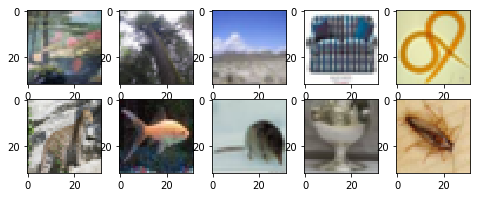

<Figure size 1440x1440 with 0 Axes>

In [5]:
f,ax = plt.subplots(2,5,figsize=(8,3))
f = plt.figure(figsize=(20,20))
for i in range(5):
    for j in range(2):
        ax[j][i].imshow(features[np.random.randint(6000)])
plt.show() 

### Getting labes 

In [6]:
# getting fine-labes of images (in the form of numberical vales from 0-99)
fine_labels = np.array(df[b'fine_labels'])

# getting coarse-labes of images (in the form of numerical values from 0-19)
coarse_labels = np.array(df[b'coarse_labels'])

# getting file_name (in the form of Name-tag)
file_name = df[b'filenames']

### Extracting Name lables from filename

In [7]:
name_label = []
for file in file_name:
    stripped = str(file).split("_s_")[0]
    name_label.append(stripped)
print("SOME LABEL NAMES: ", name_label[:40])


SOME LABEL NAMES:  ["b'bos_taurus", "b'stegosaurus", "b'mcintosh", "b'altar_boy", "b'cichlid", "b'phone", "b'car_train", "b'beaker", "b'fog", "b'rogue_elephant", "b'computer_keyboard", "b'willow_tree", "b'sunflower", "b'palace", "b'adriatic", "b'computer_keyboard", "b'bike", "b'wolf_pup", "b'squirrel", "b'sea", "b'shrew", "b'pine_tree", "b'rose", "b'surveillance_system", "b'pine", "b'table", "b'opossum", "b'quercus_alba", "b'leopard", "b'possum", "b'bike", "b'balmoral_castle", "b'acer_saccharinum", "b'lapin", "b'chimp", "b'clock", "b'streetcar", "b'male_child", "b'oriental_cockroach", "b'breakfast_table"]


## About Data

50000 labelled examples (500 per class) are provided for training, with a further 10000 examples (100 per class) used for testing.
<br>
Each images has 3 RGB colour channels and pixel dimensions 32×32 for an overall size per input of 3×32×32=3072.

In [8]:
print("No of images in CIFAR-100 dataset:", features.shape[0] , " \n")

No of images in CIFAR-100 dataset: 50000  



In [9]:
print("Dimensions of image:", features[0].shape , " \n")

Dimensions of image: (32, 32, 3)  



In [10]:
print("Total number of fine-categories:", len(set(fine_labels)) , " \n")

Total number of fine-categories: 100  



In [11]:
print("Total number of coarse-categories:", len(set(coarse_labels)) , " \n")

Total number of coarse-categories: 20  



In [12]:
print("Total number of name-labes:", len(set(name_label)) , " \n")

Total number of name-labes: 865  



### Visualisation of original data with labels

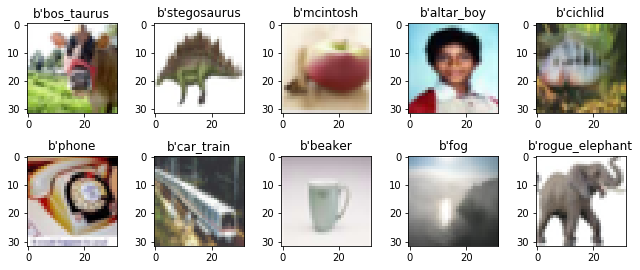

In [13]:
f,ax = plt.subplots(2,5,figsize=(9,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.tight_layout()
    plt.imshow(features[i],cmap ='gray')
    plt.title(name_label[i])
plt.show()

# Data pre processing 

### Train Test Split

#### Why Training and Testing Data Sets?
Separating data into training and testing sets is an important part of evaluating data mining models. Typically, when you separate a data set into a training set and testing set, most of the data is used for training, and a smaller portion of the data is used for testing. Analysis Services randomly samples the data to help ensure that the testing and training sets are similar. By using similar data for training and testing, you can minimize the effects of data discrepancies and better understand the characteristics of the model.<br><br>
After a model has been processed by using the training set, you test the model by making predictions against the test set. Because the data in the testing set already contains known values for the attribute that you want to predict, it is easy to determine whether the model's guesses are correct. [more](https://docs.microsoft.com/en-us/sql/analysis-services/data-mining/training-and-testing-data-sets?view=sql-server-2017)

In [14]:
features = features
fine_labels = fine_labels
x_train, x_test, y_train, y_test = train_test_split(features, fine_labels, 
                                                 test_size = 0.1, 
                                                 stratify = fine_labels)
print("Train shape (input):", x_train.shape)
print("Test shape (input):", x_test.shape)
print("Train shape (labels):", y_train.shape)
print("Test shape (labels):", y_test.shape)

Train shape (input): (45000, 32, 32, 3)
Test shape (input): (5000, 32, 32, 3)
Train shape (labels): (45000,)
Test shape (labels): (5000,)


### Normalization of Data

WHY:
If we didn't scale our input training vectors, the ranges of our distributions of feature values would likely be different for each feature, and thus the learning rate would cause corrections in each dimension that would differ (proportionally speaking) from one another. We might be over compensating a correction in one weight dimension while undercompensating in another. 
[SOURCE](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn)

In [15]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
def normalize(X_train,X_test):
    # tonormalize inputs for zero mean and unit variance
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    print("Standrad deviation",std," \nMean",mean)
    return X_train, X_test

x_train, x_test = normalize(x_train,x_test)

Standrad deviation 68.38895658894971  
Mean 121.936059453125


### Encoding of labels

This means that categorical data must be converted to a numerical form. If the categorical variable is an output variable, you may also want to convert predictions by the model back into a categorical form in order to present them or use them in some application.

In [16]:
y_train = to_categorical(y_train).astype(np.uint8)
y_test = to_categorical(y_test).astype(np.uint8)
print("Sahpe after encoding:",y_train.shape, y_test.shape)

Sahpe after encoding: (50000, 100) (10000, 100)


# Constructing VGG-NET 

Reference: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)<br>
By:**Karen Simonyan∗& Andrew Zisserman**<br>
+Visual Geometry Group, Department of Engineering Science,University of Oxford.




VGGNet is invented by VGG (Visual Geometry Group) from University of Oxford, Though VGGNet is the 1st runner-up, not the winner of the ILSVRC [ImageNet Large Scale Visual Recognition Competition](http://www.image-net.org/challenges/LSVRC/) 2014 in the classification task, which has significantly improvement over ZFNet (The winner in 2013) [2] and AlexNet (The winner in 2012) [3]. And GoogLeNet is the winner of ILSVLC 2014, I will also talk about it later.) Nevertheless, VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.

And it is the first year that there are deep learning models obtaining the error rate under 10%. The most important is that there are many other models built on top of VGGNet or based on the 3×3 conv idea of VGGNet for other purposes or other domains. That’s why we need to know about VGGNet! That is also why this is a 2015 ICLR paper with more than 14000 citations 

## Architecture

<center><img src="visual.png"></center><br><br><br>

## Creating model

### Some constants

In [17]:
weight_decay = 0.0005
img_dim = 32
number_of_classes = 100
image_shape = [img_dim, img_dim, 3]

In [18]:
def add_layer(model,num,dropout=True):
    model.add(Conv2D(num, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    if(dropout):
        model.add(Dropout(0.4))
    return model

In [19]:
def baseline_model():
    
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=image_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model = add_layer(model,64,dropout=False)

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model = add_layer(model,128,dropout=True)

    model = add_layer(model,128,dropout=False)

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model = add_layer(model,256,dropout=True)

    model = add_layer(model,256,dropout=True)
    
    model = add_layer(model,256,dropout=False)

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model = add_layer(model,512,dropout=True)
    
    model = add_layer(model,512,dropout=True)
    
    model = add_layer(model,512,dropout=False)

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model = add_layer(model,512,dropout=True)

    model = add_layer(model,512,dropout=True)

    model = add_layer(model,512,dropout=False)

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(number_of_classes))
    model.add(Activation('softmax'))
    
    return model


### Plot of the layers in the VGG-NET 

In [20]:
model = baseline_model()
plot_model(model, to_file='vgg-net.png')

### Model
<center><img src="vgg-net.png" height="50"></center>

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
__________

# Data Augmentation

Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches). Rather than performing the operations on your entire image dataset in memory, the API is designed to be iterated by the deep learning model fitting process, creating augmented image data for you just-in-time. This reduces your memory overhead, but adds some additional time cost during model training.[more](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [21]:
data_generator = ImageDataGenerator(
            # randomly rotate images in the range (degrees, 0 to 180)
            rotation_range=15, 
            
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,  
    
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,  
        
            # randomly flip images
            horizontal_flip=True,  
            
            # randomly flip images
            vertical_flip=False,  
    
            # set input mean to 0 over the dataset
            featurewise_center=False,  
    
            # set each sample mean to 0
            samplewise_center=False, 
    
            # divide inputs by std of the dataset
            featurewise_std_normalization=False,  
            
            # divide each input by its std
            samplewise_std_normalization=False, 
    
            # apply ZCA whitening
            zca_whitening=False) 
            
data_generator.fit(x_train)

### Normal Images

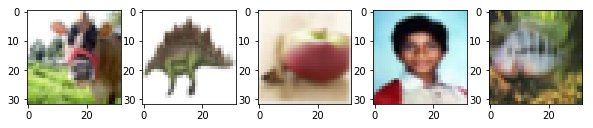

In [22]:
img_rows, img_cols = 32, 32
num_classes = 100
#The data, shuffled and split between train and test sets
(xa_train, ya_train), (xa_test, ya_test) = cifar100.load_data()

xa_train = xa_train.reshape(xa_train.shape[0], img_rows, img_cols, 3)
xa_test = xa_test.reshape(xa_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)
    
xa_train = xa_train.astype('float32')
xa_test = xa_test.astype('float32')
xa_train /= 255
xa_test /= 255

#Look at the first 9 images from the dataset
plt.figure(figsize=(10,10))
images = range(0,5)
for i in images:
    plt.subplot(550 + 1 + i)
    plt.imshow(xa_train[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

### Image flip (horizontal_flip)

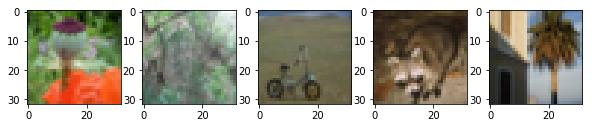

In [24]:
# Flip images vertically
datagen = ImageDataGenerator(horizontal_flip=True)

# fit parameters from data
datagen.fit(xa_train)

# Configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
for Xa_batch, yabatch in datagen.flow(xa_train, ya_train, batch_size=9):
    # Show 9 images
    for i in range(0, 5):
        plt.subplot(550 + 1 + i)
        plt.imshow(Xa_batch[i].reshape(img_rows, img_cols, 3))
    # show the plot
    plt.show()
    break

### Image rotation 

 randomly rotate images in the range (degrees, 0 to 180)

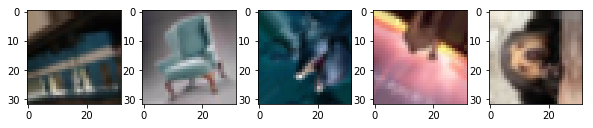

In [25]:
datagen = ImageDataGenerator(rotation_range=180)
# fit parameters from data
datagen.fit(xa_train)

# Configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
for X_batch, y_batch in datagen.flow(xa_train, ya_train, batch_size=9):
    # Show 9 images
    for i in range(0, 5):
        plt.subplot(550 + 1 + i)
        plt.imshow(X_batch[i].reshape(img_rows, img_cols, 3))
    # show the plot
    plt.show()
    break

### Width shift range

randomly shift images horizontally (fraction of total width)

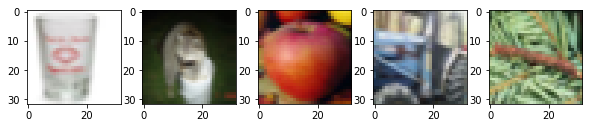

In [26]:
datagen = ImageDataGenerator(width_shift_range=0.1)
# fit parameters from data
datagen.fit(xa_train)

# Configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
for X_batch, y_batch in datagen.flow(xa_train, ya_train, batch_size=9):
    # Show 9 images
    for i in range(0, 5):
        plt.subplot(550 + 1 + i)
        plt.imshow(X_batch[i].reshape(img_rows, img_cols, 3))
    # show the plot
    plt.show()
    break

### Height shift range

randomly shift images vertically (fraction of total height)

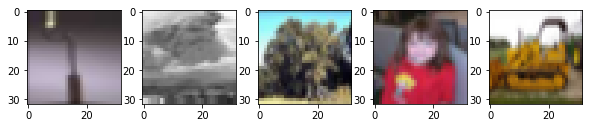

In [27]:
datagen = ImageDataGenerator(height_shift_range=0.1)
# fit parameters from data
datagen.fit(xa_train)

# Configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
for X_batch, y_batch in datagen.flow(xa_train, ya_train, batch_size=9):
    # Show 9 images
    for i in range(0, 5):
        plt.subplot(550 + 1 + i)
        plt.imshow(X_batch[i].reshape(img_rows, img_cols, 3))
    # show the plot
    plt.show()
    break

# Compiling The model

In [28]:
BATCH_SIZE = 128
EPOCHS = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [29]:
optimizer = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

# Train and Testing
##### **IS_TRAIN  = True** for training mode

In [31]:
IS_TRAIN = False
if(IS_TRAIN==True):
    history = model.fit_generator(data_generator.flow(x_train, y_train,
                                         batch_size=batch_size),
                                        steps_per_epoch=x_train.shape[0] // batch_size,
                                        epochs=EPOCHS,callbacks=[reduce_lr])
    # saving log into file log.txt file
    with opne("log.txt") as f:
        f.write(history)
        
    # saving trained model
    model.save_weights('cifar100.h5')

else:
    # loading trained model
    model.load_weights('cifar100.h5')

## Make predictions

In [32]:
pred_x = model.predict(x_test)

# How many predisctions are wrong
is_not_equal = (np.argmax(pred_x,1)!=np.argmax(y_test,1))
print(is_not_equal)

loss = sum(is_not_equal)/len(is_not_equal)
print("Loss in prediction: ",loss)

[ True False  True ... False False False]
Loss in prediction:  0.2952


## Training score and accuracy

In [33]:
train_score, train_acc = model.model.evaluate(x_train, y_train)
print("Training Score = ", train_score, " \nTraining Accuracy = ", train_acc, "%")

50000/50000 [==============================] - 566s 11ms/step
Training Score =  0.6011782531166077  
Training Accuracy =  0.99638 %


## Test score and accuracy

In [34]:
test_score, test_acc = model.model.evaluate(x_test, y_test)
print("Validation Score = ", test_score, " \nValidation Accuracy =", test_acc, "%")

10000/10000 [==============================] - 113s 11ms/step
Validation Score =  2.1116041124343874  
Validation Accuracy = 0.7048 %


## Confusion matrix

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [36]:
results = confusion_matrix(np.argmax(y_test,1), np.argmax(pred_x,1))

In [37]:
print(results)

[[88  0  0 ...  0  0  0]
 [ 0 83  0 ...  0  0  0]
 [ 0  0 68 ...  0  1  1]
 ...
 [ 0  0  0 ... 77  0  0]
 [ 0  0  5 ...  0 47  0]
 [ 0  0  0 ...  0  0 78]]


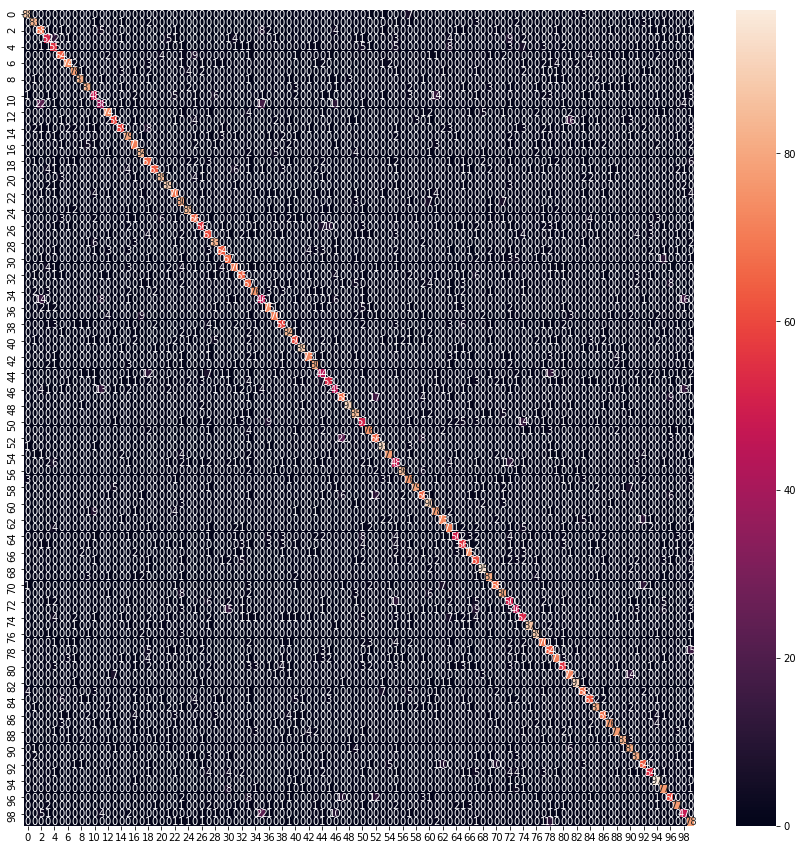

In [38]:
df_cm = pd.DataFrame(results, index = [i for i in range(100)],
                          columns = [i for i in range(100)])
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True)